# This module aims to generate VDFs (Velocity Distribution Functions) similar to those found in SPAN-I PSP data.
# Created by: Yogesh
# Contact: yphy22@gmail.com
# Date: June 13, 2025

In [1]:
# Import
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import glob
import os
import wget
import cdflib
import requests
from time import sleep
from datetime import datetime, timedelta
import bisect

In [2]:
#lets get the Energy, theta and phi values from the PSP data

# timeslice= datetime(2023, 9, 26)
timeslice= datetime(2022, 9, 4)
year  = timeslice.year
month = timeslice.month
day   = timeslice.day
user_datetime = datetime(year,month,day)

def yyyymmdd(dt) : return f"{dt.year:04d}{dt.month:02d}{dt.day:02d}"

#Import from file directory
VDfile_directoryRemote = f'http://w3sweap.cfa.harvard.edu/pub/data/sci/sweap/spi/L2/spi_sf00/{user_datetime.year:04d}/{user_datetime.month:02d}/'
VDfile_filename = f'psp_swp_spi_sf00_L2_8Dx32Ex8A_{yyyymmdd(user_datetime)}_v04.cdf'

# Define the local directory to save the file
local_directory = '/Users/data/span_l2'  # Change this to your desired directory
os.makedirs(local_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Full local file path
VDfile_filepath = os.path.join(local_directory, VDfile_filename)

# Check if the file is already downloaded
if os.path.isfile(VDfile_filepath):
    print(f"File already exists in local directory - [{VDfile_filepath}]")
    VDfile = VDfile_filepath
else:
    print("File doesn't exist. Downloading ...")
    VDfile = wget.download(VDfile_directoryRemote + VDfile_filename, out=local_directory)


#open CDF file
dat = cdflib.CDF(VDfile)

#print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile=dat

#check variable formats in cdf file
print(cdf_VDfile)
epoch           = cdf_VDfile['Epoch']
theta           = cdf_VDfile['THETA']
phi             = cdf_VDfile['PHI']
energy          = cdf_VDfile['ENERGY']
eflux           = cdf_VDfile['EFLUX']
data            = cdf_VDfile['DATA']
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))

del month,cdf_VDfile,dat,day,year,VDfile_filename,VDfile_directoryRemote,VDfile,user_datetime,timeslice

File already exists in local directory - [/Users/data/span_l2/psp_swp_spi_sf00_L2_8Dx32Ex8A_20220904_v04.cdf]
ERROR! Session/line number was not unique in database. History logging moved to new session 3
([], ['Epoch', 'TIME', 'MET', 'APID', 'SEQN', 'SEQN_DELTA', 'SEQN_GROUP', 'PKT_SIZE', 'SOURCE_APID', 'SOURCE_HASH', 'COMPR_RATIO', 'NDAT', 'DATASIZE', 'LTCSNNNN_BITS', 'ARCH_BITS', 'MODE2_ORI', 'MODE2', 'F0', 'STATUS_BITS', 'PEAK_BIN', 'PRODUCT_BITS', 'NUM_TOTAL', 'NUM_ACCUM', 'TIME_TOTAL', 'TIME_ACCUM', 'CNTS', 'DATA', 'GAP', 'QUALITY_FLAG', 'EFLUX', 'ENERGY', 'THETA', 'PHI', 'ROTMAT_SC_INST'])


In [3]:
#Getting sample slice
sample_time=np.datetime64(datetime(2022,9,4,12, 0, 0))
k = bisect.bisect_left(epoch, sample_time)
epochSlice = epoch[k]
thetaSlice = theta[k, :]
phiSlice = phi[k, :]
energySlice = energy[k, :]
efluxSlice = eflux[k, :]
dataSlice = data[k, :]

# change the shape
theta = thetaSlice.reshape((8, 32, 8))
phi = phiSlice.reshape((8, 32, 8))
energy = energySlice.reshape((8, 32, 8))

mass_p = 0.010438870  # eV/c^2 where c = 299792 km/s
charge_p = 1
#get velocity
vel = np.sqrt(2 * charge_p * energy / mass_p)

vx = vel * np.cos(np.radians(phi)) * np.cos(np.radians(theta))
vy = vel * np.sin(np.radians(phi)) * np.cos(np.radians(theta))
vz = vel * np.sin(np.radians(theta))

In [4]:
vx.shape

(8, 32, 8)

In [5]:
#define maxwellian functions
def maxwellian_3d(x, y, z, vx, vy, vz, sigma_vx, sigma_vy, sigma_vz, n):
    norm = n / ((np.pi)**1.5 * sigma_vx * sigma_vy * sigma_vz)
    exponent = -((x - vx)**2 / (sigma_vx**2) +
                 (y - vy)**2 / (sigma_vy**2) +
                 (z - vz)**2 / (sigma_vz**2))
    return norm * np.exp(exponent)


def bimaxwellian_3d(x, y, z,
                    vx1, vy1, vz1, sigma_vx1, sigma_vy1, sigma_vz1, n1,
                    vx2, vy2, vz2, sigma_vx2, sigma_vy2, sigma_vz2, n2):
    term1 = maxwellian_3d(x, y, z, vx1, vy1, vz1, sigma_vx1, sigma_vy1, sigma_vz1, n1)
    term2 = maxwellian_3d(x, y, z, vx2, vy2, vz2, sigma_vx2, sigma_vy2, sigma_vz2, n2)
    return term1 + term2

In [6]:
#Example dataset (n in cc-3, v and sigma_v in km/s)
n1=1000
vx1=-250
vy1=50 
vz1=40 
sigma_vx1=50 
sigma_vy1=50 
sigma_vz1=50
n2=100
vx2=-500
vy2=50 
vz2=40 
sigma_vx2=100 
sigma_vy2=100 
sigma_vz2=100

In [7]:
vdf=bimaxwellian_3d(vx, vy, vz,
                    vx1, vy1, vz1, sigma_vx1, sigma_vy1, sigma_vz1, n1,
                    vx2, vy2, vz2, sigma_vx2, sigma_vy2, sigma_vz2, n2)

In [8]:
np.nanmax(vdf)

np.float32(0.0011041912)

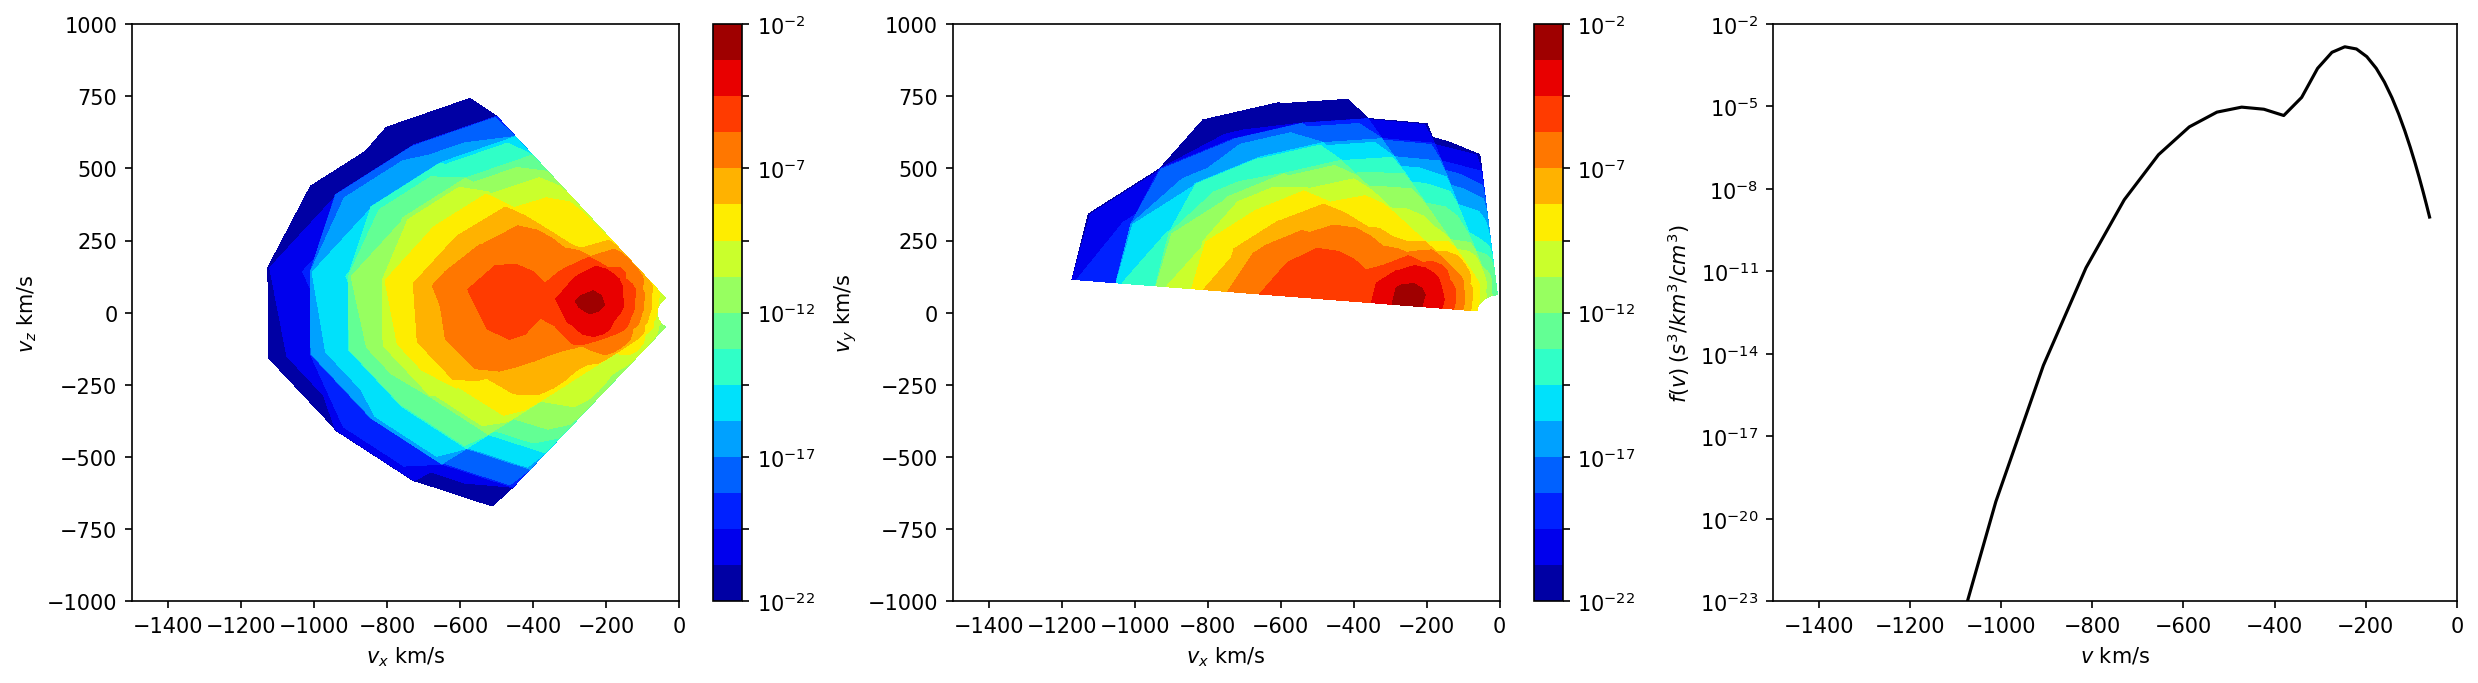

In [9]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), dpi=150)
log_levels = np.linspace(np.log10(1e-22), np.log10(1e-2), 17)
levels = 10 ** log_levels
cmap = plt.cm.jet
imax = np.unravel_index(np.nanargmax(vdf), vdf.shape)
vdf[vdf==0]=np.nan

contour0 = axs[0].contourf(vx[imax[0], :, :], vz[imax[0], :, :], vdf[imax[0], :, :], locator=ticker.LogLocator(), cmap=cmap, levels=levels)
axs[0].set_xlim(-1500, 0)
axs[0].set_ylim(-1000, 1000)
axs[0].set_xlabel('$v_x$ km/s')
axs[0].set_ylabel('$v_z$ km/s')
fig.colorbar(contour0, ax=axs[0])

contour1 = axs[1].contourf(vx[:, :,imax[2]], vy[:, :,imax[2]], vdf[:, :,imax[2]], locator=ticker.LogLocator(), cmap=cmap, levels=levels)
axs[1].set_xlim(-1500, 0)
axs[1].set_ylim(-1000, 1000)
axs[1].set_xlabel('$v_x$ km/s')
axs[1].set_ylabel('$v_y$ km/s')
fig.colorbar(contour1, ax=axs[1])

#axs[2].plot(vx[imax[0], :, :], vdf[imax[0], :, :])
axs[2].plot(vx[imax[0], :, imax[2]], np.nansum(vdf[imax[0], :, :],axis=(1)),'-k')
axs[2].set_ylim(1e-23, 1e-2)
axs[2].set_xlim(-1500, 0)
axs[2].set_yscale("log")
axs[2].set_xlabel('$v$ km/s')
axs[2].set_ylabel('$f(v) \\: (s^3/km^3/cm^3)$')
axs[2].tick_params(axis='y', which='major')
axs[2].tick_params(axis='x', which='major')
